In [1]:
import pandas as pd
import numpy as np
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

Importing dataset with features normalised

In [17]:
df_temp1 = pd.read_csv('4.Features/Features_csv/Restaurant_weights_NOR_full.csv')
df_temp1.rename(columns={'Ranking':'RankingN'}, inplace=True)

Let's add the Ranking without normalize and Style columns. Will be use for representation purposes.<br>Also we are adding back the Phone column in order to filter the dataset removing restaurants without phone or cuisines information later


In [18]:
df_default = pd.read_csv('4.Features/Features_csv/Restaurant_List_scope.csv', usecols=['Phone', 'Ranking', 'Link'])
df_styles = pd.read_csv('4.Features/Features_csv/restaurants_style.csv', usecols=['Style', 'Link'])
df_temp2 = pd.merge(df_temp1, df_default, on='Link')
df_temp3 = pd.merge(df_temp2, df_styles, on='Link')

Getting the districts for each restaurant and the price per square meter for each district

In [19]:
df_districts = pd.read_csv('4.Features/Features_csv/restaurants_districts.csv', usecols=['Link', 'District'])
df_price = pd.read_csv('4.Features/Features_csv/Dublin_median_price_by_Districts_NOR.csv')
df_price.rename(columns={'Neighbourhood':'District'}, inplace=True)
df_price.District = df_price.District.str.replace('Dublin ', '')
df_price.drop(df_price.index[10], inplace=True) # This raw is for a district outside project scope
df_price.reset_index(drop=True, inplace=True)
df_price.District = df_price.District.astype('int64')

df_dist_price = pd.merge(df_districts, df_price, on='District')
df_full = pd.merge(df_temp3, df_dist_price, on='Link')

In [20]:
df_full.columns

Index(['Name', 'Reviews', 'Price', 'Cuisines', 'Link', 'RankingN', 'Rating',
       'Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum',
       'Restaurant', 'Company', 'Company KNN', 'Liffey', 'Ranking', 'Phone',
       'Style', 'District', 'Price per sq metres'],
      dtype='object')

In [21]:
df_full = df_full.reindex(columns=['Name', 'Reviews', 'Price', 'Cuisines', 'Style', 'Phone', 'Link', 'RankingN', 'Ranking', 'Rating',
       'Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum',
       'Restaurant', 'Company', 'Company KNN', 'Liffey', 'District', 'Price per sq metres'])
df_full.rename(columns={'Price per sq metres':'Price Area'}, inplace=True)
df_full.drop_duplicates(subset='Link', keep=False, inplace=True) 

In [46]:
#df_full.to_csv('4.Features/Features_csv/restaurants_full.csv', index=False)

In [41]:
df_full = pd.read_csv('4.Features/Features_csv/restaurants_full.csv')

### Features summary

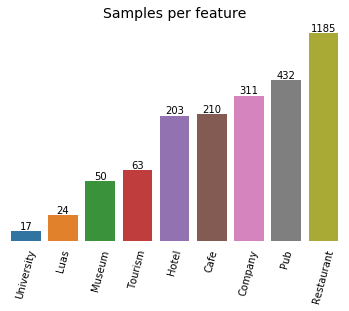

In [39]:
f_labels = {'University':17, 'Luas':24, 'Museum':50, 'Tourism':63, 
            'Hotel':203, 'Cafe':210, 'Company':311, 'Pub':432,'Restaurant':1185}

g = sns.barplot(list(f_labels.keys()), list(f_labels.values()))
g.set_yscale("log")
plt.title('Samples per feature', fontsize=14)
for item in g.get_xticklabels():
    item.set_rotation(75)
g.tick_params(labelleft=False, left=False, bottom=False) 
sns.despine(left=True, top=True, bottom=True, right=True)
g.yaxis.set_ticks_position('none') 
for p in g.patches:
        g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                   ha='center', va='bottom',color= 'black')
plt.savefig('charts/Samples_per_feature.png', bbox_inches='tight', format='png', dpi=500)

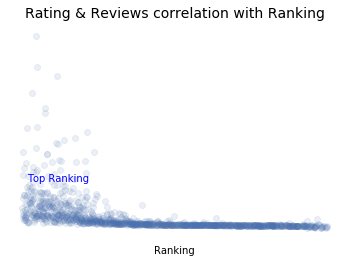

In [77]:
dff = pd.read_csv('CSVs/Restaurants_Full_Grouped_sorted.csv')
#ec=((((3000/(dff.Ranking+300))*(dff.Rating)*(dff.Reviews+3000))/50000)-0.5)
ec=((((dff.Rating*1.5)*(dff.Reviews+100))/50000)-0.2)
%matplotlib inline
plt.style.use('seaborn-deep')
plt.title('Rating & Reviews correlation with Ranking', fontsize=14)
plt.xlabel('Ranking')
sns.despine(left=True, top=True, bottom=True, right=True)
#plt.ylabel('Feature')
plt.tick_params(labelleft=False, left=False, bottom=False, labelbottom=False) 
plt.scatter(dff.Ranking,ec, alpha=0.1);
plt.annotate('Top Ranking',(30,0.01), color='b')
plt.savefig('charts/Rating_Reviews_correlation.png', bbox_inches='tight', format='png', dpi=500)

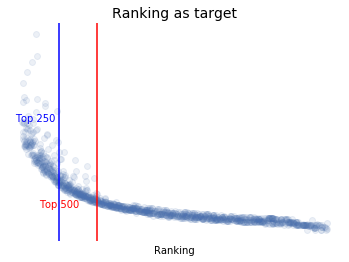

In [112]:
dff = pd.read_csv('CSVs/Restaurants_Full_Grouped_sorted.csv')
ec=((((3000/(dff.Ranking+300))*(dff.Rating)*(dff.Reviews+3000))/50000)-0.5)
#ec=((((dff.Rating*1.5)*(dff.Reviews+100))/50000)-0.2)
%matplotlib inline
plt.style.use('seaborn-deep')
#plt.title('Rating & Reviews correlation with Ranking', fontsize=14)
plt.title('Ranking as target', fontsize=14)
plt.xlabel('Ranking')
sns.despine(left=True, top=True, bottom=True, right=True)
#plt.ylabel('Feature')
plt.tick_params(labelleft=False, left=False, bottom=False, labelbottom=False) 
plt.scatter(dff.Ranking,ec, alpha=0.1);
plt.annotate('Top 250',(-50,3), color='b')
plt.annotate('Top 500',(115,0.3), color='r')
plt.axvline(250, 0,1, color='b')
plt.axvline(500, 0,1, color='r')
plt.savefig('charts/Ranking_correlation.png', bbox_inches='tight', format='png', dpi=500)

# <a id="code">Exploratory data analysis EDA</a>

In [150]:
chart_number=0

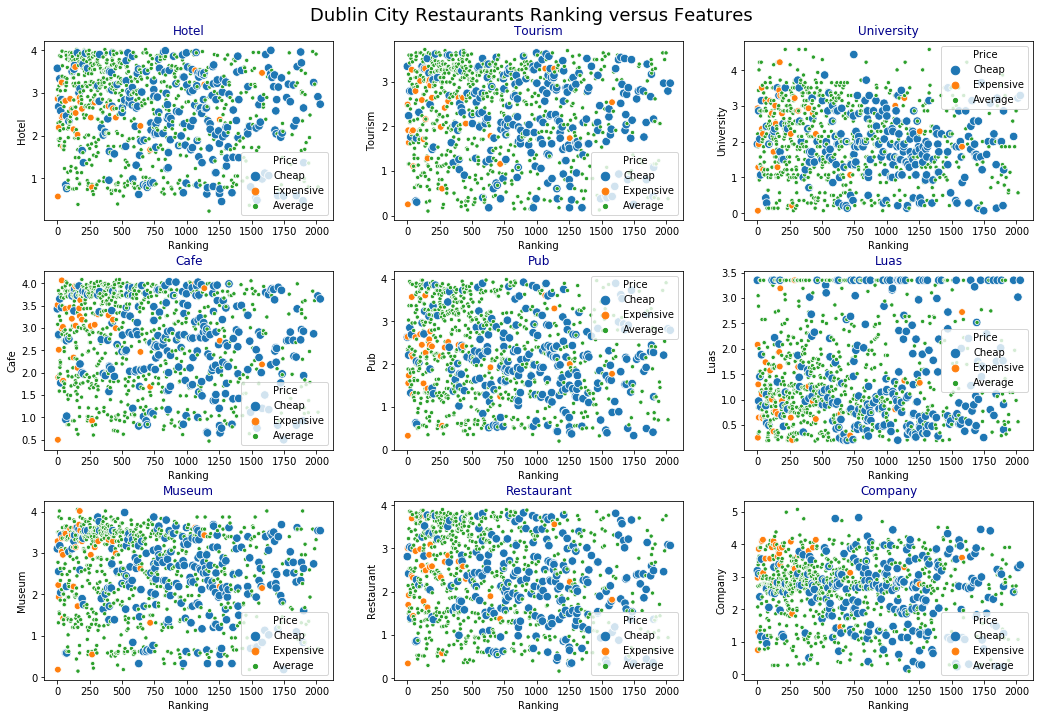

In [151]:
chart_number+=1
features = ['Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum','Restaurant', 'Company']
figures = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
axis_feat = 'Ranking'
size_feat = 'Price'
df_data = df_full

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15, 10))
fig.tight_layout(pad=3.0)
fig.suptitle('Dublin City Restaurants Ranking versus Features',y=1 , fontsize=18)
for feat, figs in zip(features, figures):
    sns.scatterplot(x=axis_feat, y=feat, hue=size_feat, size=size_feat, 
                    data=df_data, ax=axs[figs]).set_title(feat, color='darkblue')

fig.savefig('charts/FeatureSelection_{}.png'.format(chart_number), bbox_inches='tight', format='png', dpi=500)
#fig.savefig('outputs/{}_{}.png'.format(axis_feat, size_feat))

As we can see, dataset is a bit caotic. Let's see how we can filter it to improve visualization

Restaurants in red with no phone or cuisine information or less than 10 reviews

In [37]:
dfc = df_full.copy() # let's use a shorter name

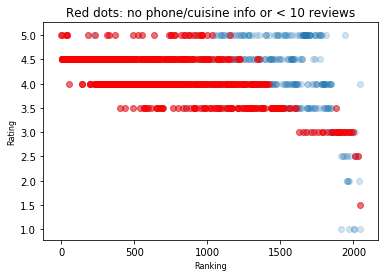

In [40]:
chart_number+=1
plt.scatter(dfc.Ranking, dfc.Rating, alpha=0.2)
y_axis = dfc.loc[(((dfc['Phone'].isnull()) | (dfc['Cuisines'].isnull()) | (dfc['Reviews'] < 10) == False )), 'Rating'].tolist()
x_axis = dfc.loc[(((dfc['Phone'].isnull()) | (dfc['Cuisines'].isnull()) | (dfc['Reviews'] < 10) == False )), 'Ranking'].tolist()
plt.scatter(x_axis, y_axis, c='red', alpha=0.5)
plt.title('Red dots: no phone/cuisine info or < 10 reviews', fontsize=12)
plt.ylabel('Rating', fontsize=8)
plt.xlabel('Ranking', y=5, fontsize=8)
plt.savefig('charts/FeatureSelection_{}.png'.format(chart_number), bbox_inches='tight', format='png', dpi=500)
plt.show()

In [42]:
print ('There\'re {} restaurants without phone or cuisine information or less than 10 reviews'.format
       (dfc.loc[((dfc['Phone'].isnull()) | (dfc['Cuisines'].isnull()) | (dfc['Reviews'] < 10)), 'Rating'].count()))

There're 333 restaurants without phone or cuisine information or less than 10 reviews


In [55]:
print ('There\'re {} restaurants without phone or cuisine information or less than 10 reviews and higher Rating than 3.5'.format
       (dfc.loc[((dfc['Phone'].isnull()) | (dfc['Cuisines'].isnull()) | (dfc['Reviews'] < 10)) & (dfc['Rating'] > 3.5), 'Rating'].count()))

There're 246 restaurants without phone or cuisine information or less than 10 reviews and higher Rating than 3.5


As we can tell, it makes no sense to see these restaurants with 3.5+ Rating. We can assume that this type of restaurant shouldn't be mixed on the Range of restaurants with 3.5+ Rating. This is due to a misclassification by the website from which we had collected the data. Instead of removing them, we'll downgrade their Ratings to 3.5 in order to have a more consistant dataset to work with.

In [56]:
#dff = dfc.drop(dfc[((dfc['Phone'].isnull()) | (dfc['Cuisines'].isnull()) | (dfc['Reviews'] < 10)) & (dfc['Rating'] > 3.5)].index)

In [66]:
dff = dfc.copy()

In [ ]:
#dfc.loc[((dfc['Phone'].isnull()) | (dfc['Cuisines'].isnull()) | (dfc['Reviews'] < 10)) & (dfc['Rating'] > 3.5), 'Rating_G']

In [67]:
dff.shape

(1184, 23)

Now let's group the ratings for future classification. We'll downgrade here previous outliers.
- Ratings 4.5 & 5 will be 5
- Ratings 4 will be 4
- Ratings up to 3.5 will be 3

In [68]:
dff.loc[(dff['Rating'] > 4), 'Rating_G'] = 5
dff.loc[(dff['Rating'] == 4), 'Rating_G'] = 4
dff.loc[(dff['Rating'] <= 3.5), 'Rating_G'] = 3
dff.loc[((dff['Phone'].isnull()) | (dff['Cuisines'].isnull()) | (dff['Reviews'] < 10)) & (dff['Rating'] > 3.5), 'Rating_G'] = 3
dff.Rating_G = dff.Rating_G.astype(int)

In [69]:
ratings_G = []
r_values_G = [5,4,3]
for r_value_G in r_values_G:
    ratings_G.append(dff.loc[(dff['Rating_G'] == r_value_G), 'Rating_G'].count())

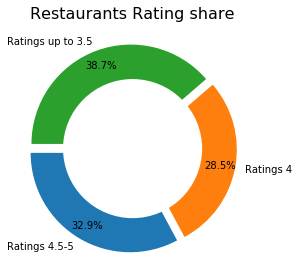

In [70]:
chart_number+=1
labels = ['Ratings 4.5-5', 'Ratings 4', 'Ratings up to 3.5']
sizes = ratings_G
explode = (0.05,0.05,0.05)
 
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=180, pctdistance=0.85, explode = explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Restaurants Rating share', fontsize=16) 
plt.tight_layout()
plt.savefig('charts/FeatureSelection_{}.png'.format(chart_number), bbox_inches='tight', format='png', dpi=500)
plt.show()

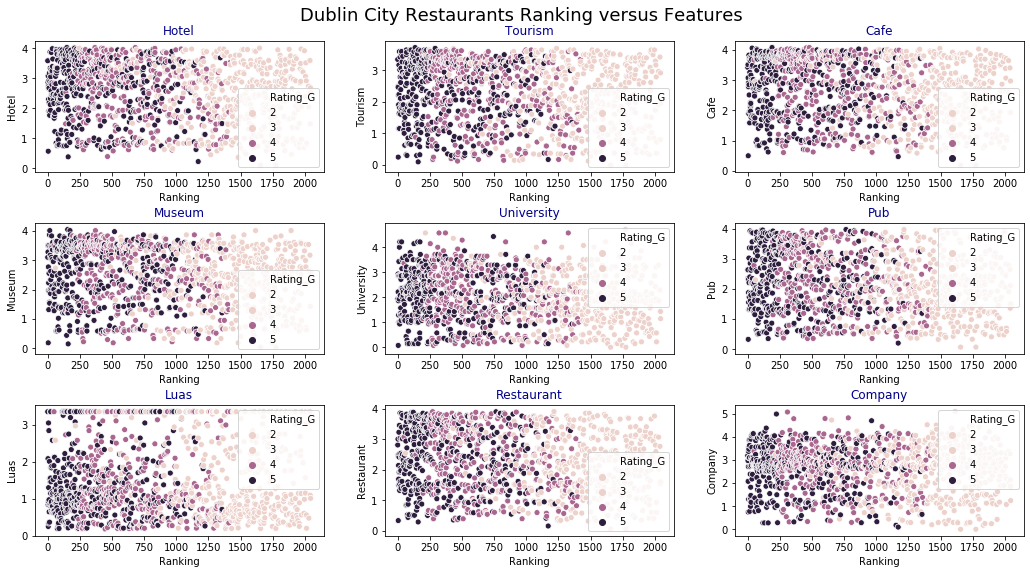

In [71]:
chart_number+=1
features = ['Hotel', 'Tourism', 'Cafe', 'Museum', 'University', 'Pub', 'Luas', 'Restaurant', 'Company']
figures = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
axis_feat = 'Ranking'
size_feat = 'Rating_G'
df_data = dff
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15, 8))
fig.tight_layout(pad=3.0)
fig.suptitle('Dublin City Restaurants Ranking versus Features', y=1, fontsize=18)
for feat, figs in zip(features, figures):
    sns.scatterplot(x=axis_feat, y=feat, hue=size_feat, 
                    data=df_data, ax=axs[figs]).set_title(feat, color='darkblue')

fig.savefig('charts/FeatureSelection_{}.png'.format(chart_number), bbox_inches='tight', format='png', dpi=500)

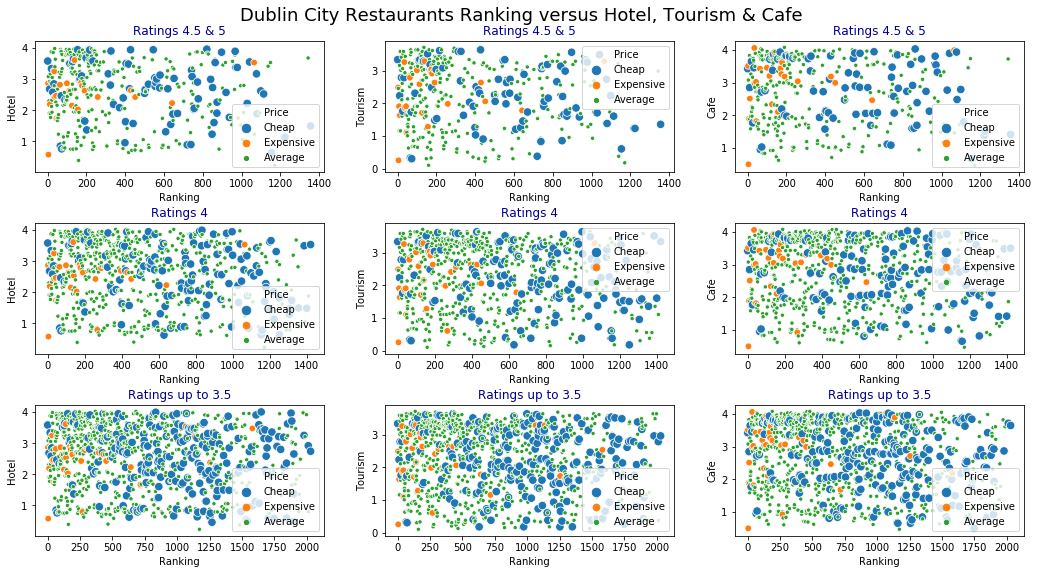

In [72]:
chart_number+=1
features = ['Hotel','Tourism','Cafe','Hotel','Tourism','Cafe','Hotel','Tourism','Cafe']
figures = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
ratings = [5,5,5,4,4,4,3,3,3]
axis_feat = 'Ranking'
size_feat = 'Price'
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15, 8))
fig.tight_layout(pad=3.0)
fig.suptitle('Dublin City Restaurants Ranking versus Hotel, Tourism & Cafe', y=1, fontsize=18)
titles = {5:'Ratings 4.5 & 5', 4:'Ratings 4', 3:'Ratings up to 3.5'}
for feat, figs, rats in zip(features, figures, ratings):
    df_data = dff.loc[(dff['Rating_G'] >= rats)]
    sns.scatterplot(x=axis_feat, y=feat, hue=size_feat, size=size_feat, 
                    data=df_data, ax=axs[figs]).set_title(titles.get(rats), color='darkblue')

fig.savefig('charts/FeatureSelection_{}.png'.format(chart_number), bbox_inches='tight', format='png', dpi=500)

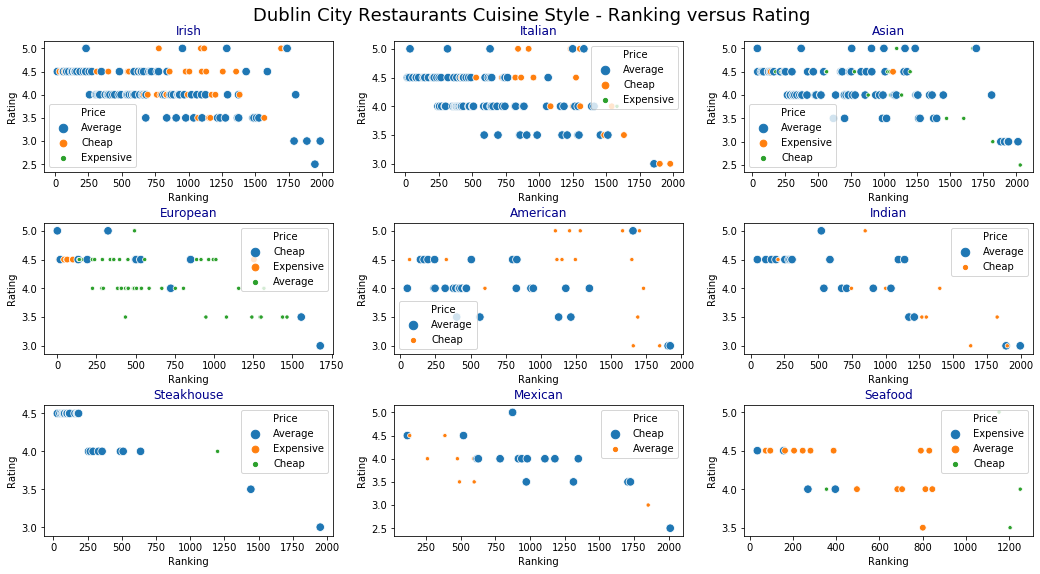

In [73]:
chart_number+=1
figures = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
styles = ['Irish', 'Italian', 'Asian', 'European', 'American', 'Indian', 'Steakhouse', 'Mexican', 'Seafood']

axis_feat = 'Ranking'
axis_y = 'Rating'
size_feat = 'Price'
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15, 8))
fig.tight_layout(pad=3.0)
fig.suptitle('Dublin City Restaurants Cuisine Style - Ranking versus Rating', y=1, fontsize=18)

for style, figs in zip( styles, figures):
    df_data = dff.loc[(dff['Style'] == style)]
    sns.scatterplot(x=axis_feat, y=axis_y, hue=size_feat, size=size_feat, 
                    data=df_data, ax=axs[figs]).set_title(style, color='darkblue')

fig.savefig('charts/FeatureSelection_{}.png'.format(chart_number), bbox_inches='tight', format='png', dpi=500)

In [95]:
#dff.to_csv('CSVs/Restaurants_Full_Grouped.csv', index=False)

### <center><a href="./4.Features/c.Luas_Tram.ipynb#feat_gen">NEXT CHAPTER</a></center>

#### <center> <a href="./0.Table_of_Contents_Code.ipynb">Table of Contents</a><br></center>